<center>

<h1>$\textbf{Analysis and Modeling of Financial Time Series}$</h1>

$\textit{Author : Antonios Kastellakis}$<br>


<h3>$\textbf{The S&P 500 Index }$</h3>

The S&P 500 index is a market capitalization-weighted index of 500 large-cap stocks traded on the two largest U.S. stock exchanges: the New York Stock Exchange (NYSE) and the Nasdaq Stock Market. These stocks are selected based on certain criteria such as market capitalization, liquidity, and financial viability and are representative of the U.S. economy. It is widely regarded as one of the best measures of the performance of the US equities market and it is often used as a benchmark for the overall performance of the US stock market. It was created by Standard & Poor's in 1957 and includes companies from various industries. The S&P 500 index is frequently used as a gauge of the health of the US economy and is tracked by investors, analysts and financial media around the world.


<h3>$\textbf{Financial Time Series}$</h3>

Economists study the functioning of economies and develop theories to explain and predict economic phenomena. Understanding the economy is important because it can affect the well-being of individuals and societies as a whole, including their standard of living, income, employment opportunities and access to goods and services. One of these theories is a mathematical framework which we refer to as *financial time series*.

A time series is generally a set of points indicating some quantity over discrete steps in time. This may include temperatures, data produced by sensors or some other value. The S&P 500 daily closing price values over a period of time is such an example. When we are dealing with finance, we call this model a financial time series.

Let us load the S&P 500 daily closing values from 1/1/2000 since 1/1/2020, using the *yfinance* module in Python which provides a more direct interface to the Yahoo Finance API and visualize the graph:

In [ ]:
!pip install arch

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.graphics import tsaplots
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Download daily S&P 500 data from Yahoo Finance from 1/1/2000 since 1/1/2020
sp500 = yf.download('^GSPC', start='2000-01-01', end='2020-12-31')

# The average of closing price in past 5 days
sp500['Ma5'] = sp500['Close'].rolling(5, min_periods = 1).mean()

# Pandas DataFrame with 6 columns, (Open, High, Low, Close, Adj Close, and Volume values)
features = ['High', 'Low', 'Open', 'Close', 'Volume', 'Ma5']
sp500

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Ma5
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1427.320007
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1418.916667
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1415.049988
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1420.333984
...,...,...,...,...,...,...,...
2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3779160000,3700.815967
2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1883780000,3696.931982
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3735.360107,3535460000,3702.122021


The concept of Mean Reversion suggests that stock prices are temporary and have a tendency to gravitate towards their average price over time. Additionally, a related concept known as Moving Average Reversion (MAR) builds upon this assumption by considering the average price as the mean of prices observed within a specified time window, such as five days.

For further details, refer to *'Li, B., Hoi, S.C.H. : On-line portfolio selection with moving average reversion, 2012'*.

Based on the views mentioned above, we added a 7th column to our dataframe in hopes it will help our model make more precise predictions.

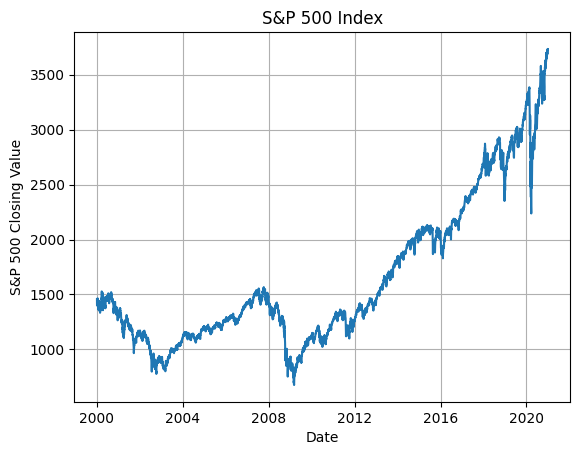

In [ ]:
# pandas DataFrame with 6 columns, (Open, High, Low, Close, Adj Close, and Volume values)

# get the date
df = sp500.reset_index()
date = df['Date']

# plot the S&P 500 data
plt.plot(date, sp500['Close'])
plt.xlabel('Date')
plt.ylabel('S&P 500 Closing Value')
plt.title('S&P 500 Index')
plt.grid()
plt.show()

The S&P 500 index is clearly in an uptrend over the years and it's not stationary. This is logical, as it kind of measures the overall performance between 500 most successful companies in the U.S. It's current value is more than 8000% up from the value in the early 60s and 70s.

<h3>$\textbf{Raw price fluctuations vs Logarithmic Returns}$</h3>

The upward trend is a common property in many financial time series, as economies tend to grow over time, which means that the value of the index may increase over time even if there are fluctuations in the short term. Therefore, studying the index's price alone may not be sufficient to compare the index's performance over different periods of time. Instead, analysts use the *returns* instead of prices for such purposes. The *logarithmic returns* of a stock or an index is defined by the equation

$$ r_t = \ln(p_t) - \ln(p_{t-1}) = \ln \left ( \frac{p_t}{p_{t-1}} \right ) $$

where $r_t$ are the logarithmic returns at time $t$ and $p_t$ is the stock or index price at time $t$. Also, we assume that the prices are equally spaced by some constant $\Delta t$ (in our case, this is one day).

For further details, refer to *'A. Chakraborti, B. Chakrabarti, S. Sinha, and A. Chatterjee, Econophysics: An Introduction, Wiley-vch, 2011'*.

The logarithmic returns have some special properties that we wish to exploit, which are not present if we used the direct returns instead, given by $p_t - p_{t-1}$. Let us visualize the direct returns and the logarithmic ones to get an idea:


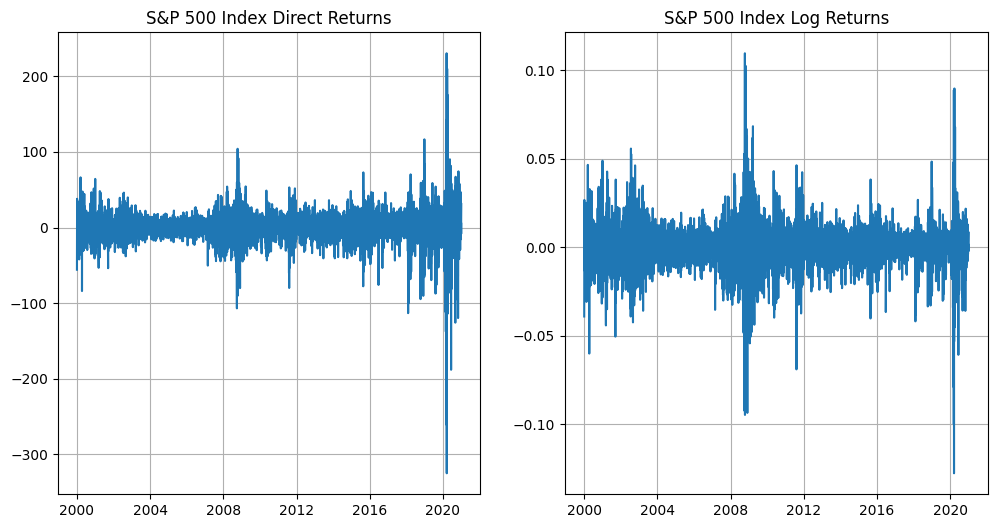

In [ ]:
# Extract daily closing values as a numpy array
sp500_close = sp500['Close'].to_numpy()

# Direct returns over time
sp500_direct_r = sp500_close[1:] - sp500_close[:-1]

# logarithmic returns over time
sp500_log_r = np.log(sp500_close[1:]) - np.log(sp500_close[:-1])

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

axes[0].plot(date[1:], sp500_direct_r)
axes[0].set_title('S&P 500 Index Direct Returns')
axes[0].grid()

axes[1].plot(date[1:], sp500_log_r)
axes[1].set_title('S&P 500 Index Log Returns')
axes[1].grid()

# Show the plot
plt.show()

In [ ]:
# Calculate ACF and PACF values
acf_values = tsaplots.acf(sp500_log_r, nlags = 30)
pacf_values = tsaplots.pacf(sp500_log_r, nlags = 30)

# Print the ACF and PACF values
print("ACF Values:", acf_values)
print("PACF Values:", pacf_values)
print( acf_values == pacf_values)

ACF Values: [ 1.00000000e+00 -1.13445846e-01 -3.48240337e-03  1.52607310e-02
 -2.57261241e-02 -1.33405047e-02 -3.62707691e-02  3.34914339e-02
 -3.02786644e-02  3.79806019e-02  1.26234007e-03 -1.49549268e-02
  4.92956585e-02 -1.52175180e-02 -2.52097802e-03 -6.36051422e-02
  7.60157265e-02 -3.77042812e-03 -4.54543149e-02 -9.66115765e-04
  2.15777229e-03 -1.76522755e-02 -2.56879495e-03  4.34387840e-03
 -7.54583595e-03 -5.20098306e-04 -1.33690773e-02  3.11160714e-02
 -5.64405572e-03  1.09891024e-02  1.48969311e-02]
PACF Values: [ 1.00000000e+00 -1.13467328e-01 -1.65719177e-02  1.31601958e-02
 -2.28511572e-02 -1.88918606e-02 -4.12141067e-02  2.54158489e-02
 -2.48567191e-02  3.29904130e-02  5.84351932e-03 -1.28254414e-02
  4.44824381e-02 -2.12120351e-03 -4.46479223e-03 -6.37786274e-02
  6.31390375e-02  1.27215096e-02 -4.02824990e-02 -2.03120278e-02
  3.62526587e-03 -2.11969499e-02 -9.07996109e-04 -3.38670286e-03
 -5.61959513e-03 -4.85029874e-03 -1.80629673e-02  3.71258807e-02
 -4.66955925e-0

<h3>$\textbf{Scaling over time and Heteroskedasticity}$</h3>

The first thing to notice is how the returns scale over time. The log-returns stay within an approximate range, whereas the bounds of the direct returns range are altered. Raw price fluctuations can vary widely depending on the value of the index, which can make it difficult to compare fluctuations at different points in time. However, log-returns account for the percentage change in price, which helps to normalize the data and makes it easier to compare fluctuations across different periods. This is because of the compression that the logarithmic function induces on the values. Additionally, log-returns are additive, which means that the return over a longer period can be calculated by summing the returns over shorter periods, which is not the case with raw price fluctuations. This allows for simple arithmetic operations, such as averaging, which can be useful for various applications.

It is worth noting that the timeseries exhibit significant heteroskedasticity, even after logarithmic transformation. Heteroskedasticity refers to the phenomenon where the variance of the data changes over time. This variability can hinder the learning process of certain algorithms, as they typically assume a consistent variance across observations. To address this issue, transforming the data is commonly employed as a solution to mitigate heteroskedasticity. The objective is to stabilize the variance and bring the distribution closer to a Normal distribution. Generally, the logarithmic transformation is an effective approach for achieving this, as it is a specific instance of the Box-Cox non-linear transformations. However, in our specific case, the timeseries still display some degree of heteroskedasticity, even after applying the logarithmic transformation.

<h3>$\textbf{Returns Rate}$</h3>

Also, the *returns rate* $R_t$ at time $t$ is closely related to log-returns as

$$ R_t = \frac{p_t - p_{t-1}}{p_{t-1}} \approx \ln \left ( \frac{p_t}{p_{t-1}} \right ) $$

The returns rate is simply the percentage change in the value of an investment over a specific period of time. Log-returns are calculated using the natural logarithm of the ratio between the final and initial values of an investment. Since the logarithmic function is continuous and differentiable, log-returns can be interpreted as the continuously compounded returns rate. This means that a log-return of 0.01 (or 1%) can be interpreted as a continuously compounded return rate of 1%.

<h3>$\textbf{Volatility Smile}$</h3>

Log-returns are also related to *stock volatility*, which measures how much the price of a stock fluctuates over time. The relationship between log-returns and stock volatility is known as the *volatility smile*. It is a common feature of financial markets where implied volatility, which is derived from options prices, varies with respect to the strike price and time to expiration. In general, the volatility smile implies that log-returns are not normally distributed, but instead have fatter tails than a normal distribution would suggest. We will come to this right after.

<h2>$\textbf{Stylized Empirical Facts}$</h2>

Over the years, analysts have extracted several statistical properties from financial time series that are present in almost every market, which are known as stylized facts. This is essential, as there is no standard procedure of how the values of such a series are produced. As a result, predicting future stock prices is out of the question. As a consequence of many independent empirical studies on the statistical properties of financial markets, there is a wide collection of stylized facts. We will be concerned with the most basic ones.

<h3>$\textbf{Log-Returns is not Gaussian}$</h3>

In order to see this, we plot the probability density function (PDF) of the log-returns along with a Gaussian distribution with the same mean and standard deviation:

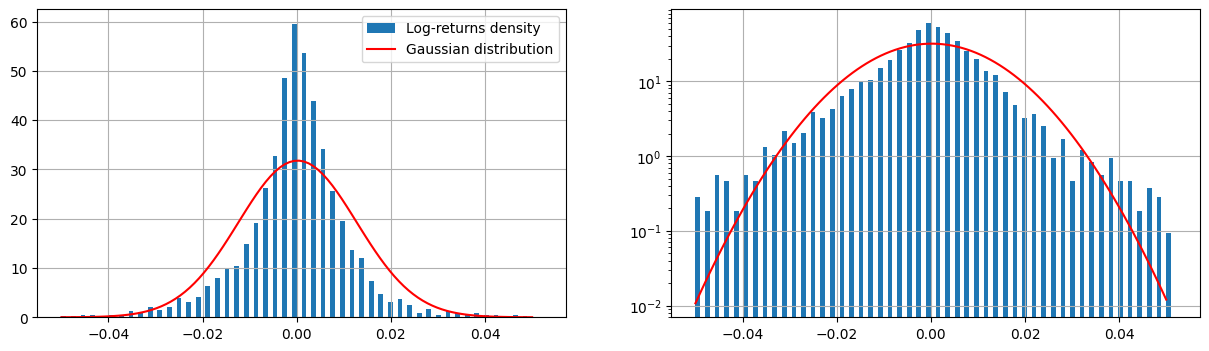

In [ ]:
# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_log_r)
sigma = np.std(sp500_log_r)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x
pdf = stats.norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()

# plot in logarithmic scale
axes[1].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.show()

On the left, we have the histogram of the log-returns along with a Gaussian distribution with the same parameters and on the right, we plot the same results in logarithmic scale to inspect in further detail. The log-returns density peak is almost doubled with respect to the Gaussian distribution. This is expected as time series with non-constant variance often have a long-tailed distribution. Also, by inspecting the right figure, we see that the tails of the log-returns do not decay as fast as the Gaussian. This property is known as *fat tails* and shows that volatility is present more often than a Gaussian distribution would predict.

It is worth noting that these two properties are not so well clarified when we increase the time scale from days to weeks or months. This is so-called *aggregational normality*.

Another way to assess if the data follow a normal distribution is by using the  Q-Q plot (Quantile-Quantile plot). A Q-Q plot, is a visual tool utilized to evaluate whether a dataset conforms to a specific theoretical distribution. The Q-Q plot compares the quantiles of the dataset with the corresponding quantiles of a chosen theoretical distribution. When examining whether the data follows a Gaussian distribution, the alignment of points on the Q-Q plot with the diagonal line is considered. If the points roughly fall along or close to the diagonal line, it indicates that the data is well approximated by the Gaussian distribution.

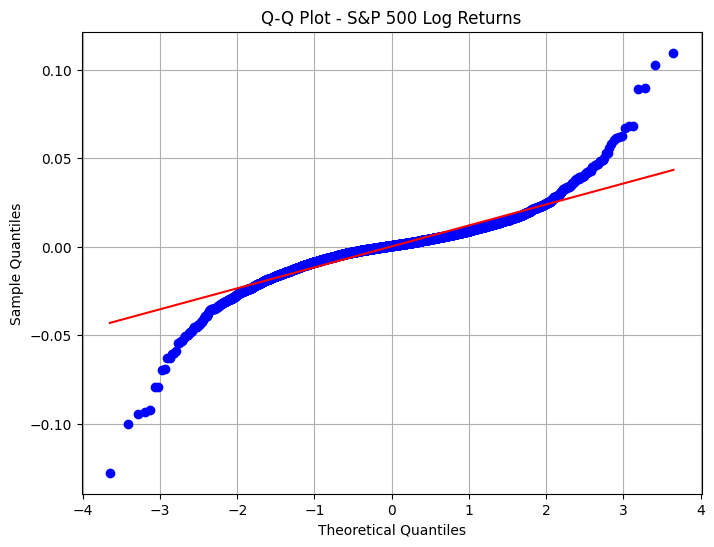

In [ ]:
# Generate the Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(sp500_log_r, dist='norm', plot=plt)
plt.title('Q-Q Plot - S&P 500 Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

<h3>$\textbf{No Linear Autocorrelation}$</h3>

The previous observation comes from a statistical perspective and is independent of time. Nonetheless, there exist stylized facts that pertain to temporal properties. One such property is the absence of linear autocorrelations. To examine this, we can calculate the *autocorrelation function (ACF)* of the log-returns of the S&P 500 across various lags.

$$ \rho (\tau) = corr(r_t, r_{t+\tau}) = \frac{cov(r_t, r_{t+\tau})}{\sigma_{r_t} \cdot \sigma_{r_{t+\tau}}} $$

where $r_t$, $r_{t+\tau}$ are the log returns, $\sigma_{r_{t}}$, $\sigma_{r_{t+\tau}}$  are the standard deviations and $cov(r_t, r_{t+\tau})$ is the covariance of the log returns between times $t$ and $t+\tau$, where $\tau$ is the lag. Since we have daily timeframe, $\tau \in \mathbb{N}^*$.

We calculate the autocorrelations of the log-returns at a range of lags $\tau \in \{1,\dots,30\}$, so the maximum lag is 30 days.

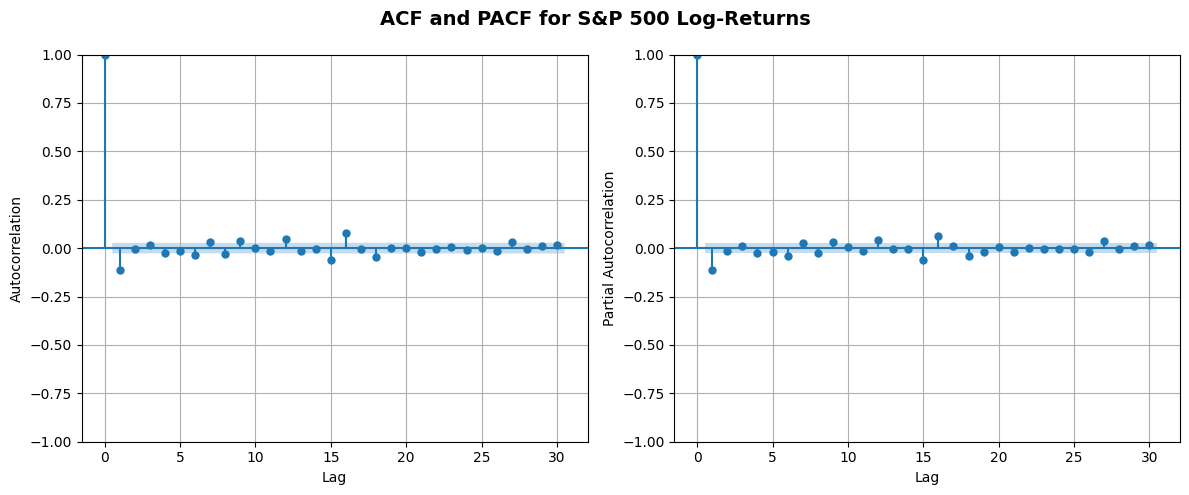

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the autocorrelations on the first subplot (ACF)
tsaplots.plot_acf(sp500_log_r, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) for S&P 500 Log-Returns')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.grid()

# Plot the partial autocorrelations on the second subplot (PACF)
tsaplots.plot_pacf(sp500_log_r, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) for S&P 500 Log-Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.grid()

# Remove the subtitles
ax1.set_title('')
ax2.set_title('')

# Set the general title
fig.suptitle('ACF and PACF for S&P 500 Log-Returns', fontsize=14, fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()


The absence of linear autocorrelations refers to the lack of predictable patterns or correlations in the successive values of a time series. In other words, it implies that the current value of a variable does not depend on its past values. If a time series exhibits no linear autocorrelations, it suggests that the series is not influenced by its own historical behavior and that each observation is independent of the previous ones.

The concept of absence of linear autocorrelations is closely related to the *efficient market hypothesis (EMH)*. The EMH suggests that financial markets are highly efficient and reflect all available information. According to the EMH, asset prices in efficient markets quickly adjust to reflect new information, making it impossible to consistently predict future price movements based on historical price patterns or any publicly available information.

However, it is worth noting that the efficiency of financial markets is a subject of ongoing debate. Empirical studies continue to investigate the efficiency of different markets and the presence of autocorrelations in various financial time series.

<h2>$\textbf{Volatility Clustering}$</h2>

The absence of autocorrelations in a time series suggests that linear models like ARIMA may not effectively capture the underlying patterns. However, there is still potential for modeling volatility in the financial markets using non-linear models such as ARCH or GARCH. These models have shown promise in capturing the volatility clustering phenomenon observed in financial markets.

Volatility clustering refers to the tendency for periods of high volatility to be followed by other high-volatility periods, and periods of low volatility to be followed by other low-volatility periods. This clustering implies that volatility is not randomly distributed but instead tends to occur in clusters over time.

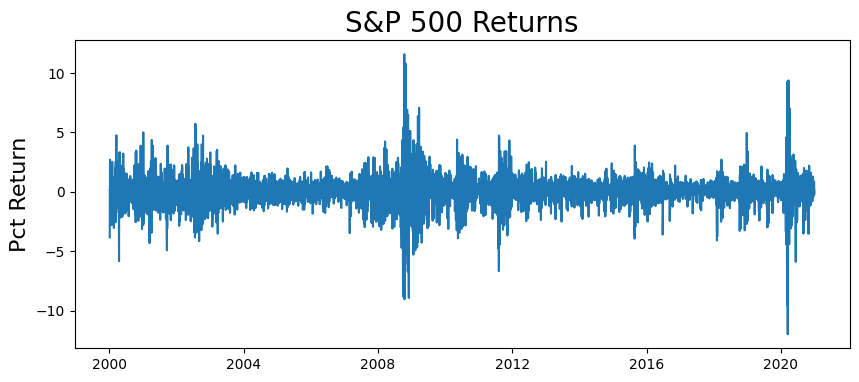

In [ ]:
# Calculate the percentage returns from the S&P 500 closing prices
Returns = 100 * sp500['Close'].pct_change().dropna()

# Plot the percentage returns
plt.figure(figsize=(10, 4))
plt.plot(Returns)

# Set the y-axis label
plt.ylabel('Pct Return', fontsize=16)

# Set the title of the plot
plt.title('S&P 500 Returns', fontsize=20)

# Display the plot
plt.show()

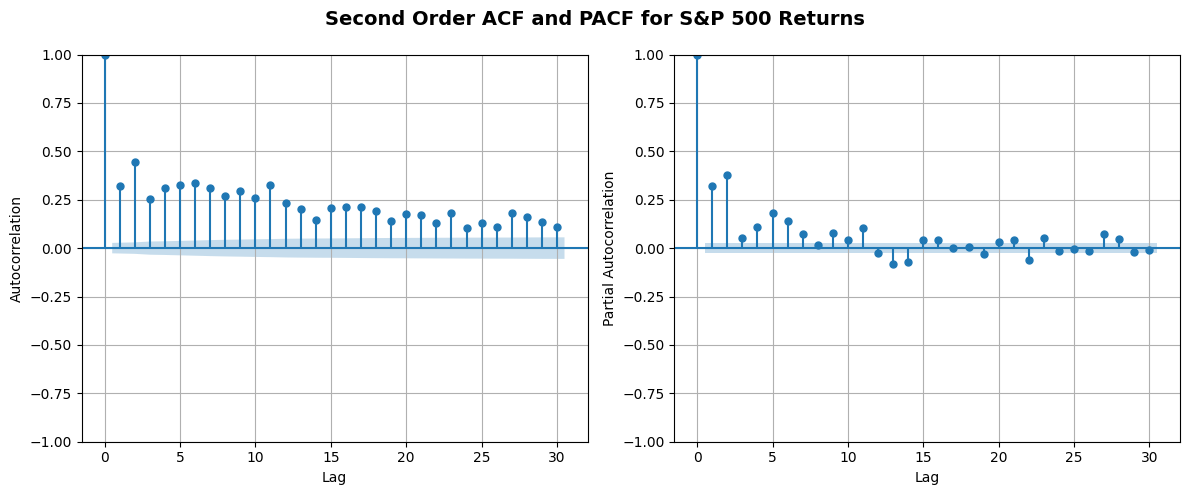

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the autocorrelations on the first subplot (ACF)
tsaplots.plot_acf(Returns**2, lags=30, ax=ax1)
ax1.set_title('Second Order Autocorrelation Function (ACF) for S&P 500 Returns')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.grid()

# Plot the partial autocorrelations on the second subplot (PACF)
tsaplots.plot_pacf(Returns**2, lags=30, ax=ax2)
ax2.set_title('Second Order Partial Autocorrelation Function (PACF) for S&P 500 Log-Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.grid()

# Remove the subtitles
ax1.set_title('')
ax2.set_title('')

# Set the general title
fig.suptitle('Second Order ACF and PACF for S&P 500 Returns', fontsize=14, fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

<h3>$\textbf{Generalized Autoregressive Conditional Heteroskedasticity (GARCH) }$</h3>

GARCH, which was introduced by Dr. Tim Bollerslev in 1986, emerged as a solution to the challenge of predicting volatility in asset prices. Dr. Bollerslev, who was a doctoral student at the time, expanded on economist Robert Engle's groundbreaking 1982 research on the $\textbf{Autoregressive Conditional Heteroskedasticity (ARCH)}$ model. Engle's model revolutionized the understanding of financial returns by recognizing that their variability is not constant over time but exhibits autocorrelation. Building upon Engle's work, Bollerslev developed the GARCH model to further capture and model the time-varying nature of volatility in asset prices.

The ARCH model involves multiplicative noise with variance given by an
AR(p) model,

$$ x_t = σ_t \cdot ϵ_t \;,  \quad \text{where} \quad σ_t^2 = \phi_0 + \phi_1 \cdot x_{t-1}^2 + \cdots \phi_p \cdot x_{t-p}^2  $$

, $\sigma_t :$ volatility, $\; \epsilon_t \sim \mathcal{N}(0,1)$: standard Gaussian white noise (GWN).

$$ Constraints: \phi_0 >0, \; \phi_i \geq 0, \; i=0,\cdots,p$$

In the generalized ARCH model the volatility has double AR dependence,

$$ x_t = σ_t \cdot ϵ_t \;,  \quad \text{where} \quad σ_t^2 = \phi_0 + \sum_{i=1}^p \phi_i \cdot x_{t-1}^2 + \sum_{j =1}^q \psi_j \cdot \sigma_{t-j}^2$$

$$ Constraints: \phi_0 >0, \; \phi_i \geq 0, \; i=0,\cdots,p, \; \psi_j \geq 0, \; j=0,\cdots,q$$

In [ ]:
def gridsearch(data, p_rng, q_rng):
    """
    Perform a grid search to find the best GARCH model based on the AIC score and certain hypothesis tests.

    Parameters:
    data (array-like): The time series data to model.
    p_rng (list): A range of values to try for the autoregressive order (p) of the GARCH model.
    q_rng (list): A range of values to try for the moving average order (q) of the GARCH model.

    Returns:
    list: A list of dictionaries containing the results of the best model and other models satisfying a condition.

    """
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p = p, q = q)
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score:
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models

def evaluate_model(residuals, st_residuals, lags=50):
    """
    Evaluate a GARCH model using hypothesis tests and metrics on the residuals.

    Parameters:
    residuals (array-like): The residuals of the GARCH model.
    st_residuals (array-like): The standardized residuals of the GARCH model.
    lags (int): The number of lags to consider for hypothesis tests (default: 50).

    Returns:
    dict: A dictionary containing the results of hypothesis tests and metrics.

    """
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

<h3>$\textbf{Model Assessment}$</h3>

The models are compared in terms of model selection criteria that
quantify the goodness of fit of each model. One such criterion is the Akaike information criterion (AIC), which is defined as follows,

$$ AIC = 2K - 2\log \mathcal{L} \approx 2k + N \log \hat{\sigma_{\epsilon}}^2$$

where $N$ is the number of points in time series, $K$ is the number of parameters and $\mathcal{L} is the likelihood of the model.

Models with lower AIC  values are preferred to models with higher
AIC values.

The objective is to create a parsimonious model, meaning it should have the fewest parameters possible based on the principle of parsimony, also known as Occam's razor. However, it is crucial for the model to pass diagnostic checks.

A parsimonious model offers several advantages. First, it is more interpretable, allowing for easier understanding and explanation of the model's behavior. Second, including irrelevant lags in the model increases the standard errors of the coefficients, reducing the reliability and precision of the model.

<h3>$\textbf{Residual Diagnostics}$</h3>

To evaluate the goodness-of-fit of a model, several checks are performed on the residuals. These checks include verifying if the residuals align with the model assumptions, exhibit zero-mean (unbiased forecast), adhere to a normal distribution, demonstrate no correlation, and maintain stationarity (homoskedasticity). If the residuals meet all of these criteria, the model is deemed consistent with the data. However, if the residuals fail to meet one or more of these properties, it indicates the need for a more suitable model that better captures the characteristics of the dataset.

<h4>$\textbf{Shapiro-Wilk test}$</h4>

The Shapiro-Wilk test is a statistical test used to assess the normality of a dataset. It is based on the Shapiro-Wilk statistic, which measures the discrepancy between the observed data and the expected normal distribution.

$$ \mathbf{H_0}: \text{ The data are drawn from a normal distribution.} $$
$$ \mathbf{H_a}: \text{ The data significantly deviates from a normal distribution.} $$

<h4>$\textbf{Ljung-Box test}$</h4>

The Ljung-Box test, also known as the Ljung-Box Q-test, is a statistical test used to assess the presence of autocorrelation in a time series.

$$ \mathbf{H_0}: \text{ The data are independently distributed.} $$
$$ \mathbf{H_a}: \text{ The data are not independently distributed.} $$

<h4>$\textbf{Engle’s ARCH test}$</h4>

The ARCH (Autoregressive Conditional Heteroscedasticity) test, which is a statistical test used to assess the presence of conditional heteroscedasticity in a time series. The ARCH test is specifically designed to detect if there are time-varying variances (volatility clustering) in the residuals of a model.

$$ \mathbf{H_0}: \text{ The conditional variances of the residuals are constant over time.} $$
$$ \mathbf{H_a}: \text{ There is presence of heteroscedasticity.} $$



In [ ]:
p_rng = range(0,10)
q_rng = range(0,10)
top_models = gridsearch(Returns, p_rng, q_rng)
print(f"The best models are: {top_models}")

In [ ]:
# Retrieve the top model
best_model = top_models[-1]

# Extract the optimal values of q and p from the top model
best_q = best_model['params']['q']
best_p = best_model['params']['p']

# Create a GARCH model using the optimal q and p values
garch = arch_model(Returns, vol='GARCH', p = best_p, q = best_q)

# Fit the GARCH model to the data
fgarch = garch.fit(disp='off')

# Obtain the residuals from the GARCH model
resid = fgarch.resid

# Calculate the standardized residuals
st_resid = np.divide(resid, fgarch.conditional_volatility)

In [ ]:
# Perform the Ljung-Box test on the GARCH residuals
lb_test_results = acorr_ljungbox(resid)

# Extract the p-values from the Ljung-Box test results
p_values = lb_test_results['lb_pvalue']

# Define the significance level
alpha = 0.05

# Check if any p-value is below the significance level
is_white_noise = any(p < alpha for p in p_values)

if is_white_noise:
    print("The GARCH residuals exhibit characteristics of white noise.")
else:
    print("The GARCH residuals do not exhibit characteristics of white noise.")


The GARCH residuals exhibit characteristics of white noise.


<h3>$\textbf{Rolling Window Forecasting}$</h3>

A rolling window forecast, also known as a rolling forecast or rolling prediction, involves making iterative predictions for a time series using a fixed-size window of historical data that moves incrementally over time. This approach enables the model to adapt to changing patterns and incorporate new information as it becomes available. By sliding the window through the data, a new forecast is generated at each step, utilizing the most recent observations while excluding older data. This allows for ongoing evaluation of the model's performance, ensuring it remains relevant and accurate in capturing the dynamics of the time series over time.

In [ ]:
rolling_predictions = []
# Test size equivalent to approximately 5 years
# Remember
test_size = 365 * 5

for i in range(test_size):
    # Set the training set using a rolling window
    train = Returns[:-(test_size - i)]

    # Create an GARCH model with specified parameters (p=2, q=2)
    model = arch_model(train, p = best_p, q = best_q)

    # Fit the GARCH model to the training data
    model_fit = model.fit(disp='off')

    # Make a one-step-ahead forecast
    pred = model_fit.forecast(horizon=1)

    # Extract the rolling prediction of volatility and append it to the list
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

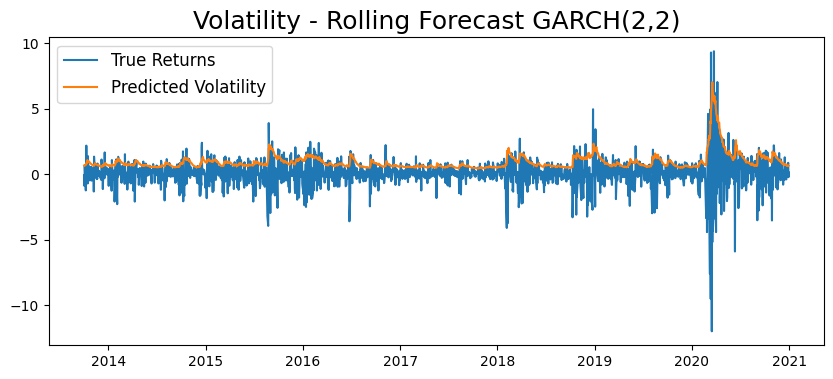

In [ ]:
# Convert the rolling_predictions list to a pandas Series
rolling_predictions = pd.Series(rolling_predictions, index=Returns.index[-365*5:])

# Create a figure with the specified size
plt.figure(figsize=(10, 4))

# Plot the true returns
true, = plt.plot(Returns[-365*5:])
# Plot the rolling predictions
preds, = plt.plot(rolling_predictions)

# Set the title of the plot
plt.title(f'Volatility - Rolling Forecast GARCH({best_q},{best_q})', fontsize=18)

# Set the legend
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=12)


<h1>$\textbf{Generative Modeling: Application in Financial Time Series}$</h1>

Generative modeling involves the creation of synthetic data that closely resembles a given dataset. It falls under the umbrella of unsupervised learning, where the goal is to train a model capable of capturing the underlying statistics and characteristics of the data. Various techniques are employed in generative modeling, such as restricted Boltzmann machines, Deep-Belief networks, and Generative Adversarial Networks (GANs). GANs, in particular, have shown promise in applications like image generation, data augmentation, feature extraction, style transfer, and text inference.

GANs consist of two neural networks: the generator and the discriminator. These networks engage in a competitive process referred to as a "zero-sum game." During training, the discriminator is first trained on a batch of real data and subsequently on synthetic data produced by the generator, which is fed with random noise. The discriminator provides feedback to penalize the generator for producing synthetic data that deviates from the real data, aiming to minimize the generator's error. Conversely, the generator, guided by the discriminator's feedback, attempts to generate data that closely resembles the real data, maximizing the discriminator's error. In an ideal scenario, where the generator produces perfect replicas of the data, the discriminator's loss approaches 50%, indicating its inability to differentiate between real and fake data. This competitive training process continues until the model achieves satisfactory performance, tailored to the specific task at hand.

The most common GAN architectures used for time series data include LSTM-GANs and WGANs.

<h3>$\textbf{LSTM-GANs}$</h3>

LSTM-GANs utilize a type of neural network called a $\textbf{Long Short-Term Memory (LSTM)}$ network, which is a type of recurrent neural network (RNN) that can remember past inputs and use that information to inform future predictions. In an LSTM-GAN, the generator is an LSTM network that takes as input a randomly generated noise vector and produces a sequence of synthetic financial time series data. The discriminator is also an LSTM network that takes as input a sequence of either real or synthetic financial time series data and outputs a probability indicating whether the input data is real or synthetic.



<h3>$\textbf{Discriminator & Generator Models}$</h3>

<h3>$\textbf{Discriminator}$</h3>

The purpose of the discriminator is to constitute a differentiable function D to classify the input data. The discriminator is expected to output 0 when inputting a fake data and output 1 when inputting a real data. Here, we choose an neural network as our discriminator with three hidden layers $h_1 ,h_2 ,h_3$ including 72, 100, 10 neurons, respectively. The Leaky ReLU is used as the activation function among the hidden layers and the sigmoid function is used in the output layer. In addition, the cross entropy loss is chosen as the loss function to optimize the neural network. In particular, we concatenate the $\mathbf{X} = \{\mathbf{x_1}, \cdots, \mathbf{x_t}\}$ and $\mathbf{\hat{x}_{t+1}}$ to get $\{\mathbf{x_1}, \cdots, \mathbf{x_t}, \mathbf{\hat{x}_{t+1}}\}$ as the fake data $\mathbf{X_{fake}}$. Similarly, we concatenate the $\mathbf{X} = \{\mathbf{x_1}, \cdots, \mathbf{x_t}\}$ and $\mathbf{x_{t+1}}$ to get the real data $\mathbf{X_{real}}$. The output of the discriminator is defined as follows:

$$ D(\mathbf{X_{fake}}) = \sigma(d(\mathbf{X_{fake}}))$$

$$ D(\mathbf{X_{real}}) = \sigma(d(\mathbf{X_{real}}))$$

where $d(·)$ denotes the output of neural network and $\sigma(·)$ denotes the sigmoid activation function. Both $\mathbf{X_{fake}}$ and $\mathbf{X_{real}}$ output a single scalar.


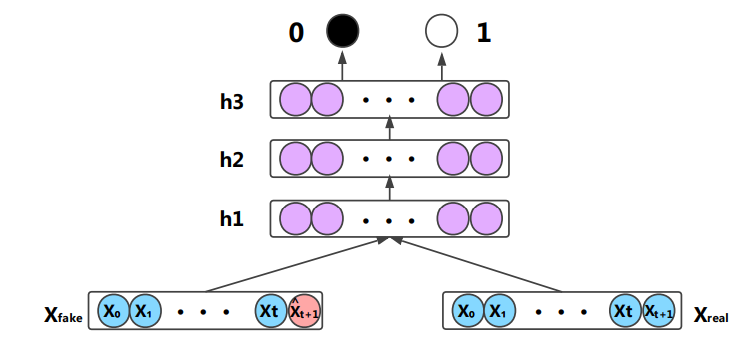

In [ ]:
# Define the discriminator model
def create_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(6, 6)))
    model.add(Dense(units=72, activation=None, kernel_initializer='random_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(units=1, activation='sigmoid'))

    return model


<h3>$\textbf{Generator}$</h3>

The generator of our model is designed by LSTM with its strong ability in processing time series data. We choose the daily data in the last 20 years with 7 financial factors to predict the future closing price. The 6 factors of the stock data in one day are High Price, Low Price, Open Price, Close Price, Volume, and Ma5 (the average of closing price in past 5 days). The 6 factors are valuable and significant in price prediction with the theory of technical
analysis, Mean Reversion, or MAR. Therefore, these factors can be used as 6 features of the stock data for the price prediction. Suppose our input is $\mathbf{X} = \{\mathbf{x_1}, \cdots, \mathbf{x_t}\}$, which consists of the daily stock data of t days. Each $\mathbf{x_k}$ in $\mathbf{X}$ is a vector, which is composed of 6 features as follows:

$$ [x_{k,i}]_{i=1}^6 = [x_{k,High},\; x_{k,low},\; x_{k,open},\; x_{k,Close},\; x_{k,Volume},\; x_{k,Ma5}] $$

With the generator, we extract the output $\mathbf{ht}$ of the LSTM and put it into a fully connected layer with 6 neurons to generate the $\mathbf{\hat{x}_{t+1}}$ which is the forecast for $\mathbf{x_{t+1}}$. From $\mathbf{\hat{x}_{t+1}}$ we can get the $\hat{x}_{t+1,Close}$ as the prediction of closing price on the $t+1$ day.

The output of the generator $G(\mathbf{X})$ is defined as follows:

$$ \mathbf{h_t} = g(\mathbf{X}), \qquad G(\mathbf{X}) = \mathbf{\hat{x}_{t+1}} = \delta(\mathbf{W_h^T \cdot h_t + b_h})$$

where $g(·)$ denotes the output of LSTM and $\mathbf{h_t}$ is the output of the LSTM with $\mathbf{X} = \{\mathbf{x_1}, \cdots, \mathbf{x_t}\}$ as the input, $\delta$ stands for the Leaky Rectified Linear Unit (ReLu) activation function. $\mathbf{W_h}$ and $\mathbf{b_h}$ denote the weight and bias in the fully connected layer. We also use dropout as a regularization method to avoiod overfitting.

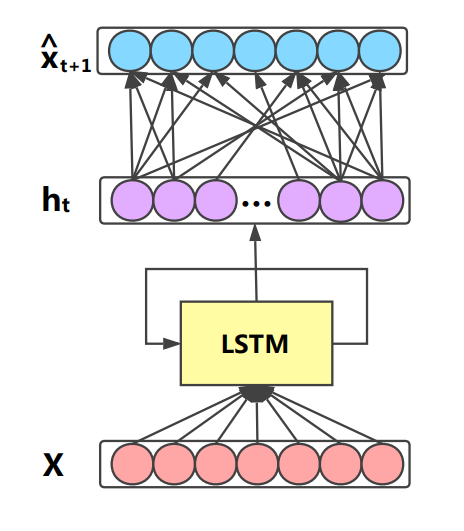

In [ ]:
# Define the generator model
def create_generator(features):
    model = Sequential()
    model.add(LSTM(units=10, input_shape=(5, 6), return_sequences=True, activation=None, kernel_initializer='random_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(len(features), activation=None))
    #model.add(LeakyReLU(alpha=0.3))

    return model

<h3>$\textbf{The Architecture of GAN}$</h3>

With the two models mentioned above, we propose our GAN architecture.  According to [5], in the two-player minimax game, both G and D try to optimize a value function. Similarly, we can define the optimization of our value
function V(G,D) as follows:

$$ D_{loss} = - \frac{1}{m} \sum_{i=1}^m log \; D( \mathbf{X_{real}^{i}}) -
 \frac{1}{m} \sum_{i=1}^m log ( 1 - D( \mathbf{X_{fake}^{i}})) $$

$$ g_{MSE} = \frac{1}{m} \sum_{i=1}^{m} ( \mathbf{\hat{x}_{t+1}^{i}} - \mathbf{x_{t+1}^{i}} )^2 $$

$$ g_{loss} = \frac{1}{m} \sum_{i=1}^{m} log (1 - D( \mathbf{X_{fake}^{i}}))$$

$$ GAN_{loss} = λ_1 \cdot g_{mse} + λ_2 \cdot g_{loss} $$

The loss function $GAN_{loss}$ is composed by $g_{MSE}$ and $g_{loss}$ with $λ_1$ and $λ_2$, respectively, which are hyper-parameters that we set manually. The reason why we put $\mathbf{X_{fake}}$ and $\mathbf{X_{real}}$ rather than $\mathbf{\hat{x}_{t+1}}$ and $\mathbf{x_{t+1}}$ in the discriminator is that we expect the discriminator to capture the correlation and time series information between $\mathbf{x_{t+1}}$ and $\mathbf{X}$.

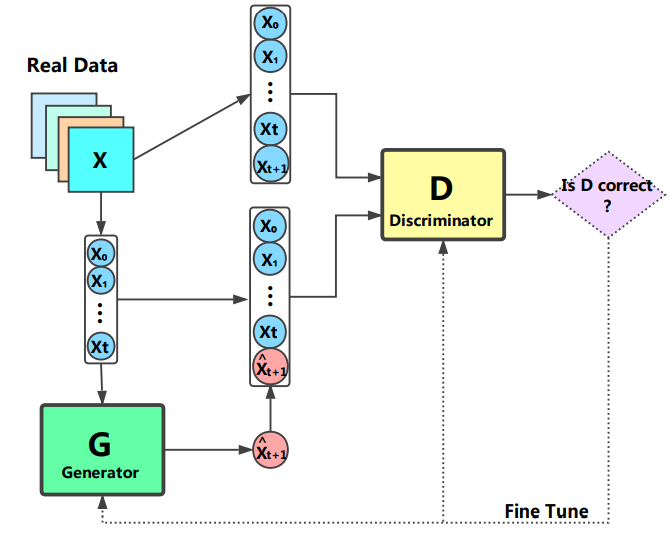

In [ ]:
def mse(y_true, y_pred):
    """
    Calculate the mean squared error (MSE) between the true and predicted values.

    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.

    Returns:
    - MSE value.
    """
    return tf.reduce_mean(tf.square(y_true[:, 3] - y_pred[:, 3]))


def mae(y_true, y_pred):
    """
    Calculate the mean absolute error (MAE) between the true and predicted values.

    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.

    Returns:
    - MAE value.
    """
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 3] - y_pred[:, 3])))


def mape(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) between the true and predicted values.

    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.

    Returns:
    - MAPE value.
    """
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:, 3] - y_pred[:, 3]) / y_true[:, 3]))


def rmse(y_true, y_pred):
    """
    Calculate the root mean squared error (RMSE) between the true and predicted values.

    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.

    Returns:
    - RMSE value.
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:, 3] - y_pred[:, 3])))

In [ ]:
# Define the loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.math.log(real_output))
    fake_loss = tf.reduce_mean(tf.math.log(1.0 - fake_output))
    return -(real_loss + fake_loss)

def generator_loss(fake_output, generated_output, real_value, lambda_1, lambda_2):
    mse_loss = tf.cast(tf.reduce_mean(tf.square(generated_output - real_value)), dtype=tf.float64)
    gloss = tf.cast(tf.reduce_mean(tf.math.log(1.0 - fake_output)), dtype=tf.float64)
    return lambda_1 * mse_loss + lambda_2 * gloss, mse_loss


In [ ]:
def generate_real_samples(dataframe, sequence_length, num_sequences):
    """
    Create samples where each data point is a time-series sequence of consecutive days.
    Each sequence is standardized by subtracting the mean and dividing by the standard deviation.

    Args:
        dataframe (pandas.DataFrame): Input dataframe containing time series data.
        sequence_length (int): Length of each time-series sequence.
        num_sequences (int): Number of sequences to generate.

    Returns:
        numpy.ndarray: New dataset with shape (num_sequences, sequence_length, num_features).

    """
    # Convert dataframe to numpy array without 'Adj Close' column
    data = dataframe.drop('Adj Close', axis=1).to_numpy()

    # Total number of days in the dataset
    n_days = data.shape[0]

    # Create an empty array to store the sequences
    sequences = np.empty((num_sequences, sequence_length, data.shape[1]))

    # Generate random start points for each sequence
    start_points = np.random.randint(0, n_days - sequence_length + 1, size=num_sequences)

    # Extract and standardize sequences from the original data
    for i, start in enumerate(start_points):
        sequence = data[start : start + sequence_length]
        # With the assumption of MAR, we compute the
        # mean and standard deviation of the data of 5 days to normalize the data
        first_five_days = sequence[:5]
        sequence_mean = np.mean(first_five_days, axis=0)
        sequence_std = np.std(first_five_days, axis=0)
        standardized_sequence = (sequence - sequence_mean) / sequence_std
        sequences[i] = standardized_sequence

    return sequences

def generate_fake_samples(generator, sequences):
    """
    Generate fake samples using a generator model.

    Args:
        generator (tf.keras.Model): Generator model.
        sequences (numpy.ndarray): Input sequences of shape (num_sequences, sequence_length, num_features).

    Returns:
        numpy.ndarray: Fake samples with shape (num_sequences, sequence_length, num_features).
    """
    num_sequences, sequence_length, num_features = sequences.shape

    # Create an empty array to store the fake samples
    X_fake = np.empty((num_sequences, sequence_length, num_features))

    # Generate fake samples for each sequence
    for i in range(num_sequences):
        # Extract the first 5 days from the sequence
        input_sequence = sequences[i, :5]

        # Predict the 6th day values using the generator
        predicted_value = generator(np.reshape(input_sequence, (1, 5, num_features)), training = False)

        # Concatenate the predicted value to create the fake sequence
        fake_sequence = np.concatenate([input_sequence, predicted_value], axis=0)

        # Store the fake sequence in the array
        X_fake[i] = fake_sequence

    return X_fake

In [ ]:
# Create the GAN model
# Define optimizer for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 =0, beta_2 = 0.9)

# Compile the discriminator model
discriminator = create_discriminator()
discriminator.compile(loss = discriminator_loss, optimizer = discriminator_optimizer, metrics=['accuracy'])

# Compile the generator model
generator = create_generator(features)
generator.compile(loss = None, optimizer = generator_optimizer, metrics = [mse , mae, mape, rmse])

def train_GAN(generator, discriminator, data, epochs, num_sequences, sequence_length, lambda_1, lambda_2):
    """
    Train a Generative Adversarial Network (GAN) with a generator and discriminator.

    Args:
        generator (tf.keras.Model): The generator model.
        discriminator (tf.keras.Model): The discriminator model.
        data (numpy.ndarray): Input data for training.
        epochs (int): Number of training epochs.
        num_sequences (int): Number of sequences in each batch.
        sequence_length (int): Length of each sequence.
        lambda_1 (float): Weight parameter for the generator loss.
        lambda_2 (float): Weight parameter for the generator loss.

    Returns:
        list, list, list: Lists containing discriminator loss, generator loss, and generator MSE loss history.

    """
    discriminator_loss_history = []
    generator_loss_history = []
    gen_mse_loss_history = []

    for epoch in range(epochs):
        gen_loss = 0
        disc_loss = 0
        mse_loss = 0

        # Group the data by year using the `groupby` function
        groups = data.groupby(data.index.year)
        num_of_groups = len(groups)

        # Iterate over the groups
        for yearly_data in groups:
            gen_loss_per_batch = 0
            disc_loss_per_batch = 0
            mse_loss_per_batch = 0

            # record the gradients for the discriminator and the generator
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate real samples
                real_samples = generate_real_samples(data, sequence_length, num_sequences)

                # Generate fake samples
                fake_samples = generate_fake_samples(generator, real_samples)

                for m in range(num_sequences):
                    # Train the discriminator
                    # Forward pass the real samples through the discriminator
                    real_output = discriminator(np.reshape(real_samples[m], (1, 6, 6)), training=True)

                    # Forward pass the fake samples through the discriminator
                    fake_output = discriminator(np.reshape(fake_samples[m], (1, 6, 6)), training=True)

                    # Calculate the discriminator loss
                    disc_loss_per_sample = discriminator_loss(real_output, fake_output)
                    disc_loss_per_batch += disc_loss_per_sample

                    # Train the generator
                    # This indexing expression extracts the closing price
                    # from the last element of each sequence in the real_samples.
                    real_values = real_samples[m, -1, 3]

                    # Predict the 6th day values using the generator
                    input_sequence = real_samples[m, :5]
                    predicted_value = generator(np.reshape(input_sequence, (1, 5, 6)), training=True)

                    # Closing price only
                    predicted_closing_price = predicted_value[0, 3]
                    gen_loss_per_sample, mse_loss_per_sample = generator_loss(fake_output, predicted_closing_price, real_values, lambda_1, lambda_2)
                    gen_loss_per_batch += gen_loss_per_sample
                    mse_loss_per_batch += mse_loss_per_sample

                # Average losses over all sequences
                gen_loss_per_batch = gen_loss_per_batch / num_sequences
                disc_loss_per_batch = disc_loss_per_batch / num_sequences
                mse_loss_per_batch = mse_loss_per_batch / num_sequences

                # compute the gradients of the discriminator and apply them
                gradients_of_discriminator = disc_tape.gradient(disc_loss_per_batch, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                # compute the gradients of the generator and apply them
                gradients_of_generator = gen_tape.gradient(gen_loss_per_batch, generator.trainable_variables)
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            # Acumulate the batch loss in each epoch
            gen_loss += gen_loss_per_batch
            disc_loss += disc_loss_per_batch
            mse_loss += mse_loss_per_batch

        # Keep track of the losses
        disc_loss = disc_loss / num_of_groups
        gen_loss = gen_loss / num_of_groups
        mse_loss = mse_loss / num_of_groups
        discriminator_loss_history.append(disc_loss)
        generator_loss_history.append(gen_loss)
        gen_mse_loss_history.append(mse_loss)

        # Print the losses for monitoring the training progress
        if epoch % 10 == 0:
            print(f'Epoch: {epoch + 1}, Discriminator Loss: {disc_loss}, Generator Loss: {gen_loss}')

    return discriminator_loss_history, generator_loss_history, gen_mse_loss_history


In [ ]:
# Train the GAN
epochs = 50
sequence_length = 6
lambda_1 = tf.constant(0.2, dtype=tf.float64)
lambda_2 = tf.constant(0.8, dtype=tf.float64)
# The number of sequences on which the GAN is train on each epoch
num_sequences = 12

# Split the dataset into training and testing
# The split will be 0.9 for training and 0.1 for testing
n_rows = int(sp500.shape[0] * 0.9)
X_train = sp500.iloc[:n_rows]
X_test = sp500.iloc[n_rows:].drop('Adj Close', axis=1).to_numpy()

# Train
d_loss, g_loss, mse_loss = train_GAN(generator, discriminator, X_train, epochs, num_sequences, sequence_length, lambda_1, lambda_2)

Epoch: 1, Discriminator Loss: 1.3786920309066772, Generator Loss: 0.30715353596007616
Epoch: 11, Discriminator Loss: 1.1180682182312012, Generator Loss: 0.5343317120241021
Epoch: 21, Discriminator Loss: 0.787068784236908, Generator Loss: 0.5226123992187737
Epoch: 31, Discriminator Loss: 0.4711284041404724, Generator Loss: 0.6679319745374949
Epoch: 41, Discriminator Loss: 0.29012590646743774, Generator Loss: 0.854728061387562


Text(0.5, 0.98, 'Losses')

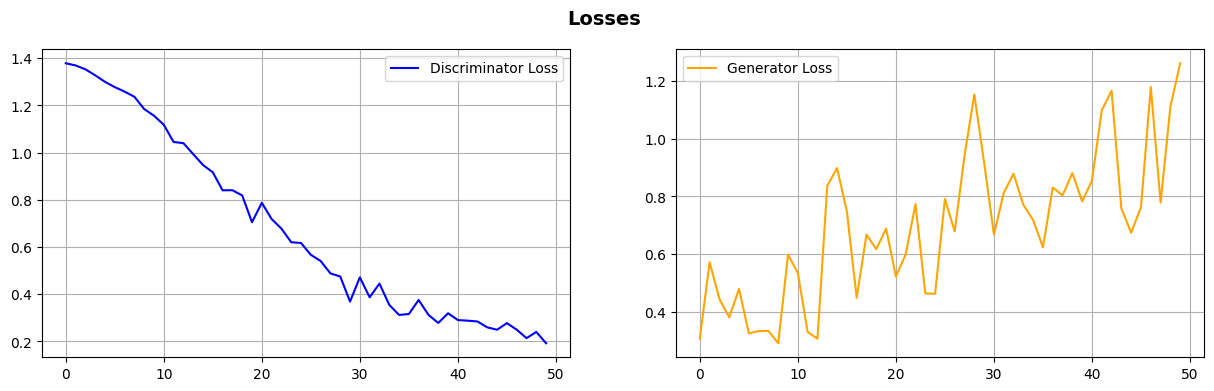

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# Plot the average critic loss as a line and the individual critic loss
axes[0].plot(d_loss, label='Discriminator Loss', color='blue')
axes[0].legend()
axes[0].grid()

# Plot the average generator loss as a line and the individual generator loss
axes[1].plot(g_loss, label='Generator Loss', color='orange')
axes[1].legend()
axes[1].grid()

# Set the super title for the figure
fig.suptitle('Losses', fontsize=14, fontweight='bold')

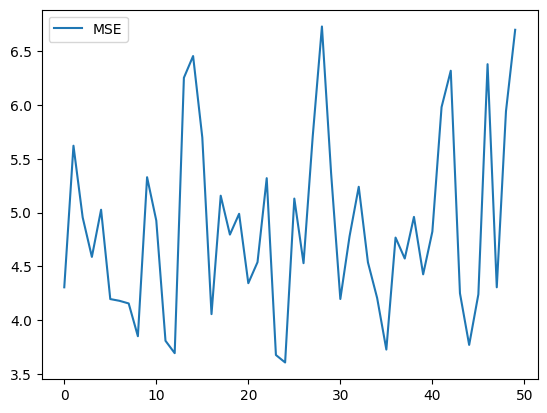

In [ ]:
plt.plot(mse_loss, label='MSE')
plt.legend()
plt.show()

In [ ]:
rolling_predictions = []
# Test size equivalent to approximately 5 years
# Remember
test_size = 50


#X_test =  X_test.drop('Adj Close', axis=1).to_numpy()

for i in range(test_size):
    # Set the training set using a rolling window
    data = X_test[i:i+6]
    # With the assumption of MAR, we compute the
    # mean and standard deviation of the data of 5 days to normalize the data
    first_five_days = data[:5]
    sequence_mean = np.mean(first_five_days, axis=0)
    sequence_std = np.std(first_five_days, axis=0)
    standardized_sequence = (data - sequence_mean) / sequence_std

    # Make prediction
    prediction = generator.predict(np.reshape(standardized_sequence[:-1], (1, 5, 6)))

    # Extract the closing value from the rolling prediction
    pred = (prediction[0, 3] * sequence_std[3]) + sequence_mean[3]

    rolling_predictions.append(pred)


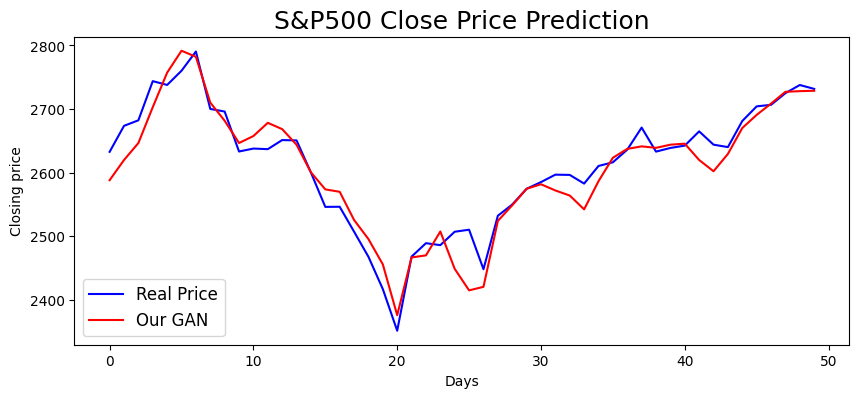

In [ ]:
# Create a figure with the specified size
plt.figure(figsize=(10, 4))

closing_price = X_test[:50, 3]

# Plot the true price in blue color
plt.plot(closing_price, label='Real Price', color='blue')

# Plot the rolling predictions in red color
plt.plot(rolling_predictions, label='Our GAN', color='red')

# Set the title of the plot
plt.title(f'S&P500 Close Price Prediction', fontsize=18)
plt.xlabel("Days")
plt.ylabel("Closing price")

# Set the legend
plt.legend(fontsize=12)

## References

1. [On-Line Portfolio Selection with Moving Average Reversion, Li, Bin and Hoi, Steven CH.](https://arxiv.org/abs/1206.4626)

2. [Autoregressive Conditional Heteroskedasticity with Estimates of the Variance of United Kingdom Inflation, Engle, Robert F.](https://www.jstor.org/stable/1912773?origin=crossref)

3. [Generalized Autoregressive Conditional Heteroskedasticity, Bollerslev, Tim.](https://doi.org/10.1016/0304-4076(86)90063-1)

4. [Stock market prediction based on generative adversarial network, Zhang, Kang and Zhong, Guoqiang and Dong, Junyu and Wang, Shengke and Wang, Yong.](https://doi.org/10.1016/j.procs.2019.01.256)

5. [Generative Adversarial Networks in finance: an overview, Eckerli, Florian and Osterrieder, Joerg](https://arxiv.org/ftp/arxiv/papers/2106/2106.06364.pdf)